In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import json
import strawberryfields as sf

In [2]:
N = 71
D = 6
filename = "basisparams_N71_D6_chi6_k1e+16_seed420.json"

In [3]:
def new_basis(basis_params,Dout=100):
    integrals_mat = np.zeros((Dout,D),dtype=np.complex128)
    for n in range(D):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.Fock(n) | q[0]
            sf.ops.Kgate(basis_params["kappa"]) | q[0]
            sf.ops.Vgate(basis_params["gamma"]) | q[0]
            sf.ops.Pgate(basis_params["s"]) | q[0]
            sf.ops.Rgate(basis_params["theta"]) | q[0]
            sf.ops.Sgate(basis_params["r"],basis_params["phi"]) | q[0]
            sf.ops.Dgate(np.abs(basis_params["alpha"]),np.angle(basis_params["alpha"])) | q[0]

        eng = sf.Engine("fock", backend_options={"cutoff_dim": Dout})
        result = eng.run(prog)
        integrals_mat[:,n] = result.state.ket()
    return integrals_mat

Douts = np.arange(D,100)
traces = np.zeros((N,len(Douts)))
with open(filename, "r") as file:
    basis_params2 = json.load(file)
    basis_params = {key: item[-1] for key, item in basis_params2.items()}
    basis_params["alpha"] = [x + 1j * y for x,y in zip(basis_params["alpha_real"],basis_params["alpha_imag"])]
for i in tqdm(range(N)):
    tmp = new_basis({key: basis_params[key][i] for key in basis_params.keys()},int(100))
    traces[i] = [np.trace(tmp[:i].T.conj()@tmp[:i])/D for i in range(D,100)]

out = []
counter = 0
for i in range(traces.shape[0]):
    specW = 1 - traces[i]
    mask = (specW[:-1] - specW[1:]) < 1e-16
    out.append(Douts[1:][mask][0])

100%|██████████| 71/71 [00:14<00:00,  5.07it/s]


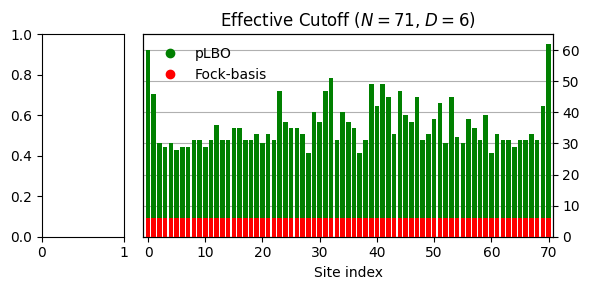

In [4]:
from matplotlib import gridspec

# Create the figure and the gridspec
fig = plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])

# Create the subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# # Customize the subplots
ax2.set_title(r"Effective Cutoff ($N=71$, $D=6$)")

# Remove the y-axis on the left side of the second column
ax2.yaxis.set_visible(False)

# Put the y-axis of the second column on the right side
ax2_right = ax2.twinx()
ax2_right.grid()
###################################
ax2_right.bar(np.arange(0,N),out,zorder=2,color="g")
ax2_right.bar(np.arange(0,N),[6]*N,zorder=3,color="r")
ax2_right.plot([],[],marker="o",color="g",ls="None",label="pLBO",zorder=10)
ax2_right.plot([],[],marker="o",color="r",ls="None",label="Fock-basis",zorder=10)
ax2.set_xlim(-0.8,N-0.3)
ax2.set_xlabel("Site index")
ax2_right.legend(loc="upper left", frameon=False)
###################################

# Show the plot
fig.tight_layout()